In [1]:
import composeml
import featuretools as ft
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

In [2]:
transactions = ft.demo.load_mock_customer(
    return_single_table=True,
    random_seed=0,
)

transactions[transactions.columns[:7]].head()

,transaction_id,session_id,transaction_time,product_id,amount,customer_id,device
0,298,1,2014-01-01 00:00:00,5,127.64,2,desktop
1,10,1,2014-01-01 00:09:45,5,57.39,2,desktop
2,495,1,2014-01-01 00:14:05,5,69.45,2,desktop
3,460,10,2014-01-01 02:33:50,5,123.19,2,tablet
4,302,10,2014-01-01 02:37:05,5,64.47,2,tablet


In [3]:
def total_spent(df_slice):
    label = df_slice["amount"].sum()
    return label

In [4]:
label_maker = composeml.LabelMaker(
    target_entity='customer_id',
    time_index='transaction_time',
    labeling_function=total_spent,
    window_size='1h',
)

In [5]:
labels = label_maker.search(
    transactions,
    minimum_data='2h',
    num_examples_per_instance=50,
    gap='2min',
)

labels.head()

Elapsed: 00:00 | Remaining: 00:00 | Progress: 100%|████████████████████| customer_id: 5/5 


,customer_id,cutoff_time,total_spent
label_id,,,
0,1,2014-01-01 02:44:25,1968.91
1,1,2014-01-01 03:30:00,1767.31
2,1,2014-01-01 03:32:10,1628.60
3,1,2014-01-01 03:34:20,1482.73
4,1,2014-01-01 03:36:30,1258.71


In [6]:
labels = labels.threshold(1200)

labels.head()

,customer_id,cutoff_time,total_spent
label_id,,,
0,1,2014-01-01 02:44:25,True
1,1,2014-01-01 03:30:00,True
2,1,2014-01-01 03:32:10,True
3,1,2014-01-01 03:34:20,True
4,1,2014-01-01 03:36:30,True


In [7]:
labels = labels.apply_lead('1h')

labels.head()

,customer_id,cutoff_time,total_spent
label_id,,,
0,1,2014-01-01 01:44:25,True
1,1,2014-01-01 02:30:00,True
2,1,2014-01-01 02:32:10,True
3,1,2014-01-01 02:34:20,True
4,1,2014-01-01 02:36:30,True


In [8]:
labels.describe()

Label Distribution
------------------
False      93
True       91
Total:    184


Settings
--------
num_examples_per_instance      50
minimum_data                   2h
window_size                    1h
gap                          2min


Transforms
----------
1. threshold
  - value:    1200

2. apply_lead
  - value:    1h



In [9]:
es = ft.EntitySet('transactions')

es.entity_from_dataframe(
    'transactions',
    transactions,
    index='transaction_id',
    time_index='transaction_time',
)

es.normalize_entity(
    base_entity_id='transactions',
    new_entity_id='sessions',
    index='session_id',
    make_time_index='session_start',
    additional_variables=[
        'device',
        'customer_id',
        'zip_code',
        'session_start',
        'join_date',
        'date_of_birth',
    ],
)

es.normalize_entity(
    base_entity_id='sessions',
    new_entity_id='customers',
    index='customer_id',
    make_time_index='join_date',
    additional_variables=[
        'zip_code',
        'join_date',
        'date_of_birth',
    ],
)

es.normalize_entity(
    base_entity_id='transactions',
    new_entity_id='products',
    index='product_id',
    additional_variables=['brand'],
    make_time_index=False,
)

es.add_last_time_indexes()

Entityset: transactions
  Entities:
    transactions [Rows: 500, Columns: 5]
    sessions [Rows: 35, Columns: 4]
    customers [Rows: 5, Columns: 4]
    products [Rows: 5, Columns: 2]
  Relationships:
    transactions.session_id -> sessions.session_id
    sessions.customer_id -> customers.customer_id
    transactions.product_id -> products.product_id



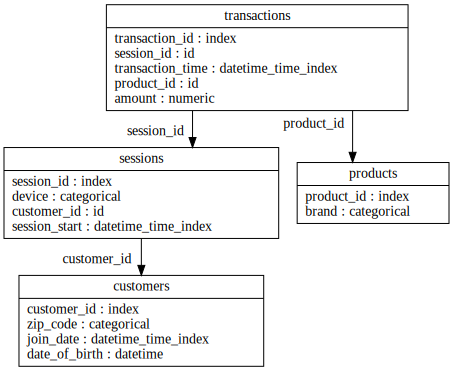

In [10]:
print(es, end='\n\n')

es.plot()

In [11]:
feature_matrix, features_defs = ft.dfs(
    entityset=es,
    target_entity='customers',
    cutoff_time=labels,
    agg_primitives=[
        'std',
        'trend',
    ],
    trans_primitives=[
        'cum_min',
        'cum_mean',
        'cum_max',
        'cum_sum',
    ],
    cutoff_time_in_index=True,
    verbose=True,
)

Built 14 features
Elapsed: 00:47 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 11/11 chunks


In [12]:
features_defs

[<Feature: zip_code>,
 <Feature: STD(transactions.amount)>,
 <Feature: TREND(transactions.amount, transaction_time)>,
 <Feature: STD(sessions.TREND(transactions.amount, transaction_time))>,
 <Feature: TREND(sessions.STD(transactions.amount), session_start)>,
 <Feature: TREND(sessions.TREND(transactions.amount, transaction_time), session_start)>,
 <Feature: CUM_MIN(STD(transactions.amount))>,
 <Feature: CUM_MIN(TREND(transactions.amount, transaction_time))>,
 <Feature: CUM_MEAN(STD(transactions.amount))>,
 <Feature: CUM_MEAN(TREND(transactions.amount, transaction_time))>,
 <Feature: CUM_MAX(STD(transactions.amount))>,
 <Feature: CUM_MAX(TREND(transactions.amount, transaction_time))>,
 <Feature: CUM_SUM(STD(transactions.amount))>,
 <Feature: CUM_SUM(TREND(transactions.amount, transaction_time))>]

In [13]:
y = feature_matrix.pop(labels.name)
x = feature_matrix.fillna(0)

x_train, x_test, y_train, y_test = train_test_split(
    x,
    y,
    train_size=.8,
    test_size=.2,
)

In [14]:
clf = RandomForestClassifier(n_estimators=10)

clf.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [15]:
y_hat = clf.predict(x_test)

print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

       False       0.86      0.83      0.84        23
        True       0.73      0.79      0.76        14

   micro avg       0.81      0.81      0.81        37
   macro avg       0.80      0.81      0.80        37
weighted avg       0.81      0.81      0.81        37

